In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append("scripts")
import rr_em

In [16]:
stim = rr_em.stimulus.RandomStimulusGenerator(num_words=1000, num_phonemes=10, phoneme_voc_size=len(rr_em.generator.phoneme2idx))
ds_args = dict(response_type="gaussian", epoch_window=(-0.1, 0.71), include_intercept=False, sample_rate=48)
dataset = rr_em.generator.sample_dataset(rr_em.get_parameters(), stim, **ds_args)
test_dataset = rr_em.generator.sample_dataset(dataset.params, stim, **ds_args)

In [17]:
dataset.Y_epoch[:, :, 0]

tensor([[-0.1740,  0.5977,  0.1415,  ..., -0.5350, -0.5438, -0.1164],
        [ 0.1306, -0.6649,  1.0544,  ..., -0.3367,  0.0820, -0.4475],
        [ 0.0405, -0.9176, -0.0269,  ..., -0.2555, -1.4172, -0.4830],
        ...,
        [-0.3597,  0.7791, -0.5206,  ..., -0.2809, -1.1134,  0.2529],
        [ 0.2529, -1.7403,  0.5092,  ...,  0.9298, -0.2370, -0.2357],
        [-0.6161,  0.1523,  0.8881,  ...,  0.8882,  1.0058,  0.0750]])

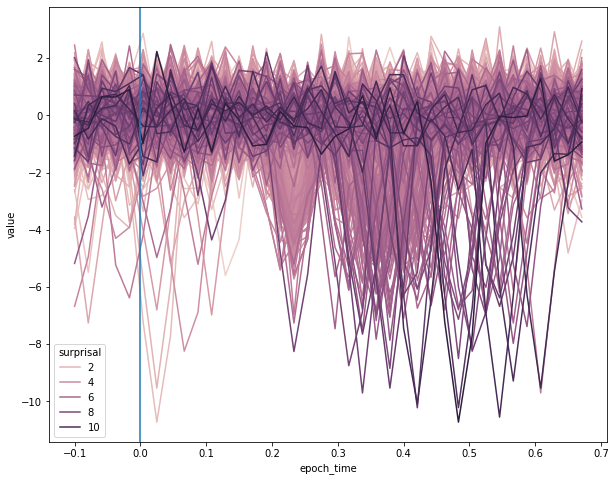

In [18]:
to_plot = pd.DataFrame(dataset.Y_epoch[:, :, 0])
to_plot.index.name = "epoch"
to_plot["surprisal"] = dataset.X_epoch[:, -1]
to_plot = to_plot.melt(id_vars=["surprisal"], var_name="epoch_time")
to_plot["epoch_time"] /= dataset.sample_rate
to_plot["epoch_time"] += dataset.epoch_window[0]

plt.subplots(figsize=(10, 8))
sns.lineplot(data=to_plot, x="epoch_time", y="value", hue="surprisal")
plt.axvline(0.0)

## MLE regression

In [60]:
from sklearn.model_selection import KFold

n_splits = 4
tmin, tmax = 0.1, 0.4
encoder = rr_em.TemporalReceptiveField(tmin, tmax, dataset.sample_rate, ["abc"], alpha=0)

X_scatter = rr_em.rr.scatter_response_model(
    dataset.X_epoch,
    torch.zeros(dataset.X_epoch.shape[0]).long(),
    dataset.phoneme_onsets + dataset.word_onsets.unsqueeze(1),
    sample_rate=dataset.sample_rate,
    total_samples=dataset.Y.shape[0])

tensor([[   56,     0],
        [   83,     0],
        [  135,     0],
        ...,
        [41180,     0],
        [41217,     0],
        [41255,     0]])

----

## EM regression with latent recognition

In [61]:
param_grid = [rr_em.get_parameters() for _ in range(5)]

In [62]:
weights, encoders = rr_em.fit_em(dataset, param_grid, test_dataset, n_iter=5, trf_alpha=1e-2)

tensor([-2220933.5000, -2223466.0000, -2208177.0000, -2224469.2500,
        -2222042.2500])
tensor([0., 0., 1., 0., 0.])
Train: [tensor(0.9036), tensor(0.)]
Test: [tensor(0.9419), tensor(0.)]
tensor([-1683131.2500, -1619292.7500, -2009391.3750, -1605071.0000,
        -1745341.0000])
tensor([0., 0., 0., 1., 0.])
Train: [tensor(0.5973), tensor(0.)]
Test: [tensor(0.5993), tensor(0.)]
tensor([-2307259.2500, -2074192.7500, -3508506.5000, -1998666.5000,
        -2377003.2500])
tensor([0., 0., 0., 1., 0.])
Train: [tensor(0.5973), tensor(0.)]
Test: [tensor(0.5993), tensor(0.)]
tensor([-2307259.2500, -2074192.7500, -3508506.5000, -1998666.6250,
        -2377003.2500])
tensor([0., 0., 0., 1., 0.])
Train: [tensor(0.5973), tensor(0.)]
Test: [tensor(0.5993), tensor(0.)]
tensor([-2307259.2500, -2074192.7500, -3508506.5000, -1998666.5000,
        -2377003.2500])
tensor([0., 0., 0., 1., 0.])
Train: [tensor(0.5973), tensor(0.)]
Test: [tensor(0.5993), tensor(0.)]


In [63]:
encoders[0]

tensor([[-9.9124e-03],
        [-2.6297e-03],
        [-3.1500e-03],
        [ 6.6325e-03],
        [ 1.1054e-03],
        [ 9.8316e-05],
        [ 1.2204e-02],
        [ 2.1932e-02],
        [-6.1455e-03],
        [ 1.0205e-02],
        [-1.0164e-02],
        [ 3.0250e-04],
        [ 1.2293e-02],
        [ 1.8222e-03],
        [ 9.2750e-03]])

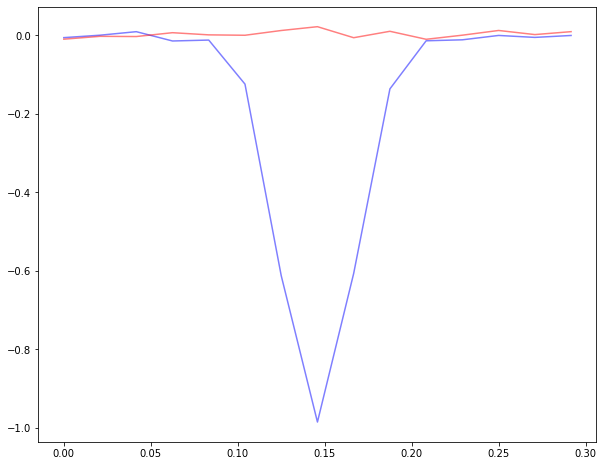

In [64]:
def plot_encoder(idx, **kwargs):
    response_coef = encoders[idx][:, 0]
    plt.plot(np.arange(response_coef.shape[0]) / dataset.sample_rate, response_coef.numpy(), **kwargs)
plt.subplots(figsize=(10, 8))
plot_encoder(-1, color="blue", alpha=0.5)
plot_encoder(0, color="red", alpha=0.5)

In [65]:
weights

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]])

<AxesSubplot:xlabel='component', ylabel='value'>

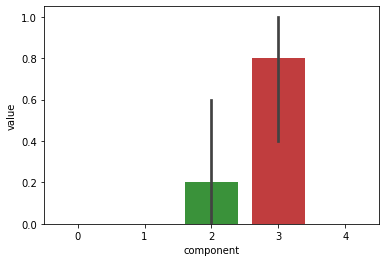

In [66]:
weight_df = pd.DataFrame(weights)
weight_df.index.name = "iter"
to_plot = weight_df.reset_index().melt(id_vars=["iter"], var_name="component")

# sns.FacetGrid(data=to_plot, row="iter").map(sns.barplot, "component", "value")
sns.barplot(data=to_plot, x="component", y="value")

In [67]:
to_plot.groupby("component").value.mean().sort_values(ascending=False).head(10)

component
3    0.8
2    0.2
0    0.0
1    0.0
4    0.0
Name: value, dtype: float32

In [68]:
thresholds = {k: params.threshold.numpy() for k, params in enumerate(param_grid)}
to_plot["threshold"] = to_plot.component.map(thresholds)

In [69]:
to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum())

iter
0    0.933767
1    0.572390
2    0.572390
3    0.572390
4    0.572390
dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

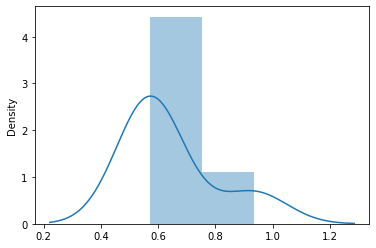

In [70]:
sns.distplot(to_plot.groupby("iter").apply(lambda xs: (xs.value * xs.threshold).sum()))

In [71]:
dataset.params.threshold

tensor(0.5780)